# Classification of Cancer associated Mutations from Literature using Machine Learning

Use the "Run" button to execute the code.

In [76]:
#pip install jovian --upgrade --quiet

In [77]:
# Execute this to save new versions of the notebook
#jovian.commit(project="jovian-ml-project-030122",filename="jovian-ml-project-030122")

### <font color='green'>Import the essential libraries</font>

In [78]:
#import jovian
import pandas as pd
import numpy as np
#import requests
#import xml.etree.ElementTree as ET
#import time
import re
#from tqdm import tqdm
%matplotlib inline

In [79]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore')

In [80]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# sns.set_style('darkgrid')
# matplotlib.rcParams['font.size'] = 14
#matplotlib.rcParams['figure.figsize'] = (9, 5)
# matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [81]:
#tqdm.pandas(desc="progress bar")

 ### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"> A cancerous tissue can have thousands of genetic mutations (Variations), which are discovered using genome sequencing. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations. MSKCC intends the Data scientist to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.</font>

<a id='top'>**Beginning of Notebook**</a>

[model train text data](#train_data)

### <font color='green'>Exploratory Data Analysis</font>

###  references
  - https://github.com/ghostintheshellarise/2021HackForRare
  - https://widdowquinn.github.io/2018-03-06-ibioic/02-sequence_databases/09-KEGG_programming.html
  - https://bioservices.readthedocs.io/en/master/kegg_tutorial.html
  - https://bioservices.readthedocs.io/en/master/index.html

In [82]:
test_submit=pd.read_csv("y_pred_stage2.csv")

In [83]:
test_submit.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.246086,0.124970,0.037631,0.240181,0.058882,0.089237,0.181960,0.006104,0.014948
1,2,0.163249,0.157760,0.029698,0.166447,0.061905,0.056034,0.343224,0.005785,0.015899
2,3,0.164260,0.169408,0.025412,0.238202,0.053039,0.059834,0.266599,0.006214,0.017031
3,4,0.179123,0.162089,0.032706,0.169243,0.055664,0.061590,0.319256,0.005516,0.014814
4,5,0.146846,0.248545,0.032790,0.223710,0.071800,0.052905,0.205449,0.005322,0.012633


In [84]:
test_submit.columns

Index(['ID', 'class1', 'class2', 'class3', 'class4', 'class5', 'class6',
       'class7', 'class8', 'class9'],
      dtype='object')

In [85]:
test_submit_val=test_submit.drop('ID',axis=1)

In [86]:
lst_test_submit=[]
for index,row in test_submit_val.iterrows():
    #print([1 if i==max(row) else 0 for i in row])
    lst_test_submit.append([1 if i==max(row) else 0 for i in row])

In [87]:
lst_test_submit=pd.DataFrame(lst_test_submit)

In [88]:
test_submit_final=pd.merge(test_submit['ID'],lst_test_submit,how="inner",left_index=True,right_index=True)

In [89]:
test_submit_final.columns=test_submit.columns

In [90]:
test_submit_final.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,1,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,1,0,0
3,4,0,0,0,0,0,0,1,0,0
4,5,0,1,0,0,0,0,0,0,0


In [91]:
test_submit_final.to_csv("stage2_submission_310322.csv",header=True,index=False)

#### train data

In [92]:
train_text_df = pd.read_csv('training_text.zip', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"],compression='zip')

In [93]:
train_variant_df = pd.read_csv('training_variants.zip',compression='zip')

In [94]:
train_text_df.shape, train_variant_df.shape

((3321, 2), (3321, 4))

In [95]:
train_text_df.columns, train_variant_df.columns

(Index(['ID', 'Text'], dtype='object'),
 Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object'))

In [96]:
# merging the text and variation data
train_df = pd.merge(train_variant_df,train_text_df,on='ID')

In [97]:
train_text_df.head(n=4)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...


In [98]:
train_variant_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [99]:
train_df.shape

(3321, 5)

In [100]:
train_df.loc[0,:]

ID                                                           0
Gene                                                    FAM58A
Variation                                 Truncating Mutations
Class                                                        1
Text         Cyclin-dependent kinases (CDKs) regulate a var...
Name: 0, dtype: object

In [101]:
# taking a sample of the dataset
#train_df = train_df.sample(frac=0.2,random_state=222)

In [102]:
#train_df=train_df.groupby('Class',group_keys=False).apply(lambda x: x.sample(frac=0.4)) # proportionate sampling

We have taken a sample of the training data

In [103]:
train_df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [104]:
var_text=train_df.loc[0,['Variation','Text']]

In [105]:
var_text

Variation                                 Truncating Mutations
Text         Cyclin-dependent kinases (CDKs) regulate a var...
Name: 0, dtype: object

In [106]:
def surround_text(motif_span,text):
    """returning the context of the mutation"""
    upstream = motif_span[0] - 100
    downstream = motif_span[1] + 100
    context = text[upstream:downstream]
    return context

In [107]:
import re

def var_variations(var_text):   
    """this function is mapping all protien mutation labels in the text"""
    motif_var = var_text[0]
    print(motif_var)
    text=var_text[1]
    if isinstance(text[1],str):
        text_len = len(text)
        while text_len>0:
            print("*******")
            motif_match = re.search(motif_var,text) 
            if motif_match is not None:
                motif_span = motif_match.span()
                motif_group = motif_match.group()                
                context_ = surround_text(motif_span,text)
                #print(motif_span)
                print(motif_group)
                
                print(context_)
                print("=======")
                text = text[motif_span[1]:]
                text_len = len(text)
            else:
                break
    else:
        word_list = ["NA"]
    return motif_match

In [108]:
var_variations(var_text)

Truncating Mutations
*******


In [109]:
import re

def all_variations(var_text):   
    """this function is mapping all protien mutation labels in the text"""
    motif = r'\s[A-Z]\d+[A-Z]\s'
    motif_var = var_text[0]
    #print(motif_var)
    text=var_text[1]
    if isinstance(text[1],str):
        text_len = len(text)
        while text_len>0:
            print("*******")
            motif_match = re.search(motif,text)             
            if motif_match is not None:
                motif_span = motif_match.span()
                motif_group = motif_match.group()  
                print("motif_group ", motif_group)
                print("motif_var ", motif_var)
                if str(motif_group.strip()) != str(motif_var.strip()): # very important to strip else shows                    
                    context_ = surround_text(motif_span,text)          # no match 
                    print(context_)
                    print("=======")
                text = text[motif_span[1]:]
                text_len = len(text)
            else:
                break
    else:
        word_list = ["NA"]
    return motif_match
all_variations(var_text)

*******
motif_group   Y2H 
motif_var  Truncating Mutations
omology with the human FAM58A gene product [whose proposed name is cyclin M (11)]. We thus performed Y2H mating assays to determine whether human CDK10 interacts with human cyclin M (Fig. 1 A–C). The longe
*******
motif_group   Y2H 
motif_var  Truncating Mutations
nd Cdi1 (KAP), which are known binding partners of other CDKs (Fig. 1B). CDK1 and CDK3 also produced Y2H signals with cyclin M, albeit notably weaker than that observed with CDK10 (Fig. 1B). An interaction
*******
motif_group   Y2H 
motif_var  Truncating Mutations
m an interaction complex. (A) Schematic representation of the different protein isoforms analyzed by Y2H assays. Amino acid numbers are indicated. Black boxes indicate internal deletions. The red box indic
*******
motif_group   Y2H 
motif_var  Truncating Mutations
nternal deletions. The red box indicates a differing amino acid sequence compared with CDK10 P1. (B) Y2H assay between a set of CDK proteins expre

In [110]:
'Q249E' == 'Q249E'

True

In [ ]:
#train_df['Text'].map(lambda x:x.split() if isinstance(x,str) else [])

In [ ]:
train_df['Text'].map(max_mutations).head()

In [ ]:
#train_df['Variation'].tolist()

In [ ]:
from collections import Counter

In [ ]:
def common_mutations(text):
    match_pat = re.compile('([\s][A-Z][\d][\d][\d][A-Z][\s])')
    if isinstance(text,str):
        xval=Counter(re.findall(match_pat,text))
        if xval.most_common(1):
            return xval.most_common(3)
        return "NA"
    return "NA"

In [ ]:
def common_mutations_len(text):
    if isinstance(text,str):
        match_pat = re.compile('([\s][A-Z][\d][\d][\d][A-Z][\s])')
        xval=Counter(re.findall(match_pat,text))
        return len(xval)
    return 0

In [ ]:
train_df["commn mutations"]=train_df['Text'].map(common_mutations_len)

In [ ]:
train_df[(train_df['Class']==5) & (train_df['Gene']=="BRCA1")].nunique()

In [ ]:
for n in range(9):
    print(n+1," ",train_df[(train_df['Class']==(n+1)) & (train_df['Gene']=="BRCA1")]['Variation'].nunique())

in BRCA1, class 1, class 4,class 5, class 6 are well represented

calculating the distance between texts

In [111]:
brca_class1_id = train_df[(train_df['Class']==1) & (train_df['Gene']=="BRCA1")]['ID'].tolist()

In [112]:
brca_class1_text = train_df[(train_df['Class']==1) & (train_df['Gene']=="BRCA1")]['Text'].tolist()

In [113]:
brca_class1_text_split = [set(text.split()) for text in brca_class1_text] 

In [114]:
brca_class1_text_split

[{'Proteolysis',
  'sensitivity;',
  'predict',
  '(either',
  'nonspecific',
  'PMSA',
  'diverse',
  'crystallographic',
  'corrected',
  'HEK293T',
  'display',
  'System',
  'instructions.',
  'bands',
  'series',
  'albeit',
  'S2).',
  'amino',
  'assign',
  'them,',
  'instrumental',
  'either',
  'S3).',
  'folding',
  'p21',
  'constitutive',
  'scored',
  'BACH1,',
  'recognized',
  'manuscript;',
  'likelihood',
  'cloned',
  'proteinprotein',
  'G1706A,',
  'research',
  'patients',
  'previously',
  'phosphopeptide-binding',
  'Potential',
  'make',
  'anticipate',
  'interactions,',
  'tumor',
  '(http://cancerres.aacrjournals.org/).',
  'individual',
  'large,',
  'cluster',
  'method,',
  'represent',
  'suppression.',
  '35',
  'fluctuation',
  'include',
  'DNA-binding',
  'Thus,',
  'Online',
  'limits',
  'results',
  'V1736A',
  'SDSPAGE.',
  'Only',
  'dissection',
  'reveal',
  'cycle',
  'tandem',
  'vectors',
  'Dual-Luciferase',
  'fused',
  'reduction',
  'ac

In [120]:
len(brca_class1_id) , len(brca_class1_text_split)

(60, 60)

In [129]:
brca_class1 = list(zip(brca_class1_id,brca_class1_text_split))

In [122]:
from itertools import combinations
from itertools import product

In [166]:
def text_match(data1,data2):
    idx_x=[]
    idx_y=[]
    val=[]
    for item1,item2 in product(brca_class1,brca_class1):
        if np.in1d(item1[1],item2[1]):
            #print(item1[0]," ",item2[0]," ",len((item1[1]).intersection(item2[1]))," ",np.in1d(item1[1],item2[1]))
            idx_x.append(item1[0])
            idx_y.append(item2[0])
            val.append(len(item1[1].intersection(item2[1])))
            #print(item1[0]," ",item2[0])        
            #print(item1[0]," ",item2[0]," ",len((item1[1]).intersection(item2[1]))," ",len(np.intersect1d(item1[1],item2[1])))          
            #print(item1[0]," ",item2[0]," ",len(np.intersect1d(item1[1],item2[1])))   
    df=pd.DataFrame({"idx_x":idx_x,"idx_y":idx_y,"val":val})
    return df
    

In [167]:
df=text_match(brca_class1,brca_class1)

In [172]:
df.pivot_table(index="idx_x",columns="idx_y",values="val",fill_value=0)

idx_y,2420,2421,2422,2424,2431,2432,2436,2438,2439,2441,2443,2455,2463,2465,2470,2474,2475,2478,2482,2483,2486,2491,2501,2506,2510,2513,2522,2523,2524,2525,2542,2552,2554,2557,2567,2569,2577,2578,2579,2581,2582,2583,2586,2592,2596,2598,2599,2600,2614,2619,2634,2639,2645,2650,2652,2653,2659,2664,2670,2677
idx_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2420,1455,0,0,0,0,0,1455,1455,0,0,0,0,0,0,1455,0,0,0,0,0,1455,0,0,0,0,0,1455,1455,1455,0,0,1455,0,0,0,0,1455,1455,1455,0,0,0,0,1455,0,0,0,0,0,0,0,0,0,0,0,0,1455,0,1455,0
2421,0,4136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2422,0,0,2162,0,0,0,0,0,0,0,0,2162,0,0,0,0,0,2162,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2162,2162,0,0,0,0,2162,0,0,0,0,0,2162,0,0,0,0,0,0,0,0,2162,0,0,0,0
2424,0,0,0,1116,0,1116,0,0,0,0,1116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2431,0,0,0,0,5982,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2432,0,0,0,1116,0,1116,0,0,0,0,1116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2436,1455,0,0,0,0,0,1455,1455,0,0,0,0,0,0,1455,0,0,0,0,0,1455,0,0,0,0,0,1455,1455,1455,0,0,1455,0,0,0,0,1455,1455,1455,0,0,0,0,1455,0,0,0,0,0,0,0,0,0,0,0,0,1455,0,1455,0
2438,1455,0,0,0,0,0,1455,1455,0,0,0,0,0,0,1455,0,0,0,0,0,1455,0,0,0,0,0,1455,1455,1455,0,0,1455,0,0,0,0,1455,1455,1455,0,0,0,0,1455,0,0,0,0,0,0,0,0,0,0,0,0,1455,0,1455,0
2439,0,0,0,0,0,0,0,0,3716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
for x in product(lsta,lstb):
                  print(x)

('cat', 'man')
('cat', 'woman')
('dog', 'man')
('dog', 'woman')


In [44]:
train_df[train_df['Class']==2]

,ID,Gene,Variation,Class,Text
1923,1923,SMO,L221R,2,Introduction Uncontrolled activation of the He...
2971,2971,KIT,P577_D579del,2,To analyze a multi-institutional series of typ...
97,97,TGFBR2,R537P,2,Transforming growth factor β (TGFβ) plays a ke...
3108,3108,DNMT3B,Amplification,2,"Abstract Human cancers, including breast canc..."
330,330,ROS1,Fusions,2,Oncogenic gene fusions involving the 3’ region...
2761,2761,BRAF,D287H,2,ERK signaling requires RAS-induced RAF dimeriz...
1220,1220,PIK3CB,N553S,2,Deregulation of the PI3K signaling pathway is ...
3012,3012,KIT,N822Y,2,We report the rare family in which cutaneous m...
770,770,ERBB2,V794M,2,Resistance to HER2-targeted therapies remains ...
3040,3040,KIT,K558_E562del,2,Abstract In subsets of gastrointestinal stroma...


![](https://imgur.com/kO8UAXb.png)

image courtesy http://igbiologyy.blogspot.com/2014/03/chromosomes-dna-genes-and-alleles.html

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"><i>Gene</i> is a stretch of DNA encoding a specific functional molecule, a protein. Variation is <i>Mutation</i>,  which occurs in the gene and changes the function of the protein. Proteins are made up of 20 amino acids and these are designated by the following alphabets; A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y and V. In the variation column, the first alphabet is the orginal amino acid, the number is the physical position in the gene where the change has occured and the last alphabet is the changed amino acid. The Text dataset contains the information for the Gene, the Variation and the Class column in the variants dataset. The 2 datasets are linked by the common ID column</font>

### The distribution of mutations per gene in the dataset

In [79]:
mutation_pattern=train_df.groupby(['Gene'])[['Variation']].aggregate("count").sort_values("Variation",ascending=False)

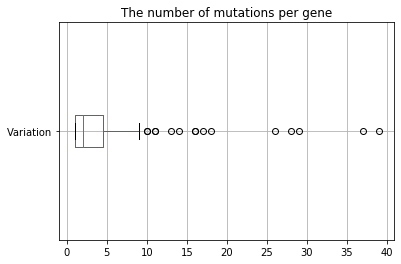

In [80]:
mutation_pattern[['Variation']].boxplot(vert=False);
plt.title("The number of mutations per gene");

In [81]:
mutation_pattern.shape

(155, 1)

In [82]:
mutation_pattern['Variation'].median()

2.0

In [83]:
mutation_pattern['Variation'].mode()

0    1
dtype: int64

In [84]:
from scipy.special import factorial

def poisson(k, lamb):
    """poisson pdf, parameter lamb is the fit parameter"""
    return (lamb**k/factorial(k)) * np.exp(-lamb)

In [85]:
lamb=mutation_pattern['Variation'].mean()

In [86]:
k=mutation_pattern['Variation'].to_numpy()

In [87]:
k=np.sort(k)

In [88]:
y=poisson(k,lamb)

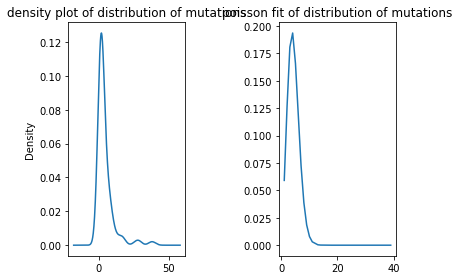

In [89]:
plt.subplot(1,2,1)
mutation_pattern['Variation'].plot.density();
plt.title("density plot of distribution of mutations")
plt.subplot(1,2,2)
plt.plot(k,y);
plt.title("poisson fit of distribution of mutations")
plt.tight_layout()

In [90]:
mutated_genes=train_df['Gene'].to_list()

### <font style="font-size:18px;font-family:arial;color:blue;text-indent:100px;line-height: 0.8;word-spacing: 10px"> Mutation acquisition is a rare event. The Poisson distribution is used to describe the distribution of rare events in a large population. For example, at any particular time, there is a certain probability that a particular cell within a large population of cells will acquire a mutation.                                                                                   -Frank H. Stephenson, in Calculations for Molecular Biology and Biotechnology (Second Edition), 2010. The distribution of mutations per gene in this dataset follows the usual pattern of Poisson distribution seen in general for mutations. 3321 mutations, or variations, are distributed in 195 genes. 14 genes have more than 20 mutations, which are often classified in different classes. It would be worthwhile to investigate, why certain mutations are classified in certain specific classes </font>

### <font color='green'>The distribution of classes in the dataset </font>

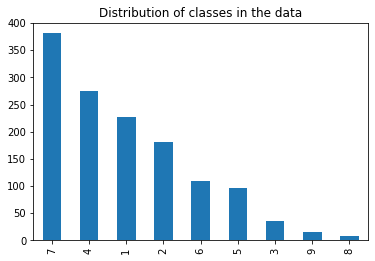

In [35]:
train_df["Class"].value_counts().plot(kind='bar');
plt.title("Distribution of classes in the data");

### <font color='blue'>The mutations are distributed into 9 classes, from class 1 to class 9.The distribution of the classes is imbalanced </font>

In [36]:
train_df[train_df['Class']==8]['Gene'].nunique()

7

In [37]:
train_df[train_df['Class']==7]['Gene'].nunique()

77

In [38]:
train_df[train_df['Class']==1]['Gene'].nunique()

91

In [42]:
for n in range(9):
    print(n+1," ",train_df[train_df['Class']==(n+1)]['Gene'].nunique())
    

1   91
2   59
3   14
4   64
5   29
6   32
7   77
8   7
9   8


### <font color="blue"> The largest class, class 7, has 108 genes which is almost half of all the mutated genes, while class 8, the smallest class has 12 genes. Let us see if all genes in class 7 have the same number of mutations per gene </font>

In [ ]:
test_variant_df=pd.read_csv('test_variants.zip',compression='zip')

In [ ]:
train_variant_df.head()

#### <font color='blue'>Are the position of the mutations for a gene in the train and test datasets same ? </font>

In [ ]:
compare_train_test_variant=pd.merge(train_variant_df,test_variant_df,how='outer',left_on='Gene',right_on='Gene')

In [ ]:
compare_train_test_variant[compare_train_test_variant['Gene']=='CBL']

#### <font color='blue'> The position and nature of mutations in the train and test dataset are different,and hence, we cannot transfer the class annotation directly from train to text </font>

In [ ]:
train_df[train_df['Class']==7].groupby('Gene')[['Variation']].count().boxplot(vert=False);

In [ ]:
train_df[train_df['Class']==7]['Variation'].nunique()

In [ ]:
def gene_class(i):
    return train_df[train_df['Class']==i]['Gene'].drop_duplicates().tolist()

In [ ]:
class_gene_list=[]
for i in range(1,10):
    var_name='class'+str(i)+"_genes"
    var_name=gene_class(i)
    class_gene_list.append(var_name)    

### <font color='blue'> The pattern of mutations per gene, is same as the overall dataset and hence,no obvious numerical pattern is present in classifying the mutations in class 7. Let us furthere explore a few other possibilites for the classification </font>

### <font color='green'>The Signalling Pathways in Cancer</font>

![](https://i.imgur.com/yk4ib0M.jpg)

### <font color='blue'> Proteins encoded by respective genes, function together in elaborate sequences called <i>Pathways<i> ,to create the final outcome. For cancer, the sequence mostly starts with a signal outside the cell. Proteins called receptors recieve the signal, and pass it on to a sequence of other proteins downstream,finally to a protein called Transcription Activator, which then switches other genes on and off to make the cancer cell survive and proliferate. Here, we will attempt to see, if the classification is based on these pathways, and we will test class 7 as an example </font>

### Pathway analysis with Bioservices library and KEGG Database

In [ ]:
#!pip install bioservices

Bioservices is a Python package that provides access to many Bioinformatices Web Services (e.g., UniProt) and a framework to easily implement Web Services wrappers (based on WSDL/SOAP or REST protocols)

In [ ]:
from Bio.KEGG import REST
from bioservices.kegg import KEGG
#from collections import deque
import networkx as nx
from IPython.display import Image
import time
import re

#### <font color ='blue'>KEGG PATHWAY is a collection of manually drawn pathway maps representing our knowledge of the molecular interaction, reaction and relation networks for:
1. Metabolism
    Global/overview   Carbohydrate   Energy   Lipid   Nucleotide   Amino acid   Other amino   Glycan
    Cofactor/vitamin   Terpenoid/PK   Other secondary metabolite   Xenobiotics   Chemical structure
2. Genetic Information Processing
3. Environmental Information Processing
4. Cellular Processes
5. Organismal Systems
6. Human Diseases
7. Drug Development
</font>    

In [ ]:
kegg_obj=KEGG()

#### the get method gets the data pertainng to ALK gene *'ALK') for humans ('hsa') from the KEGG database

In [ ]:
print(kegg_obj.get("hsa:ALK"))

#### get the list of all human genes from the KEGG Database and use re module to extract gene name

In [ ]:
human_gene_list=kegg_obj.list('hsa')

In [ ]:
human_gene_list=human_gene_list.split('\n')

In [ ]:
human_gene_list[0]

In [ ]:
re.sub('[\t;]',',',human_gene_list[0])

In [ ]:
re.search('\t\w+','hsa:100616498\tMIR378E, mir-378e; microRNA 378e').group()[1:]

In [ ]:
def get_kegg_indices(human_gene_list):
    """ this function gets the gene name and KEGG Database IDs"""
    gene_kegg_id_dict={}
    for item in human_gene_list:
        try:
            kegg_id=re.search('^\w+:\w+',item).group()
        except:
            kegg_id='no_entry'
        try:
            gene=re.search('\t\w+',item).group()[1:]
        except:
            gene='no_gene'            
        gene_kegg_id_dict[gene]=kegg_id
    return gene_kegg_id_dict    

In [ ]:
def map_mutation_kegg(mutated_genes,human_gene_list):
    """this function maps the mutated genes to KEGG Database IDs"""
    print("mutated genes in class",len(mutated_genes))
    print("genes in KEGG Database ",len(human_gene_list))
    mut_gene_kegg=[]
    kegg_gene_dict=get_kegg_indices(human_gene_list)
    for mut_gene in mutated_genes:
        if mut_gene in kegg_gene_dict:
            gene_tup=(mut_gene,kegg_gene_dict[mut_gene])
            mut_gene_kegg.append(gene_tup)
    return mut_gene_kegg        

#### get the KEGG gene IDs for mutated genes for class 7

In [ ]:
class_7_mutated_kegg=map_mutation_kegg(class_7_genes,human_gene_list)

In [ ]:
def df_gene_pathway(mutated_genes):    
    """this function maps the pathways from KEGG Database to the mutated genes"""
    df_gene_pathway=pd.DataFrame(columns=["gene","pathway"])
    for gene in tqdm(mutated_genes):    
        try:
            pathway_origin=kegg_obj.get_pathway_by_gene(gene,"hsa")
            pathway_list=list(set(pathway_origin.keys()))
            for pathway in pathway_list:
                path_obj=kegg_obj.get(pathway)
                path_name=kegg_obj.parse(path_obj)['NAME'][0]          # get the name of the pathway 
                path_name=re.sub(' -\s\w*\s\w*\s\(\w*\)',"",path_name) # remove the trailing text after hyphen
                df_gene_pathway=df_gene_pathway.append({"pathway":path_name,"gene":gene},ignore_index=True)
        except:
            print("no data for ",gene)
    return df_gene_pathway       

In [ ]:
def gene_pathway_csv(class_gene_list,human_gene_list):
    """this function maps all pathways to all genes in each class"""
    for i in range(10):
        class_mutated_kegg=map_mutation_kegg(class_gene_list[i],human_gene_list)
        class_gene_pathway=df_gene_pathway(class_gene_list[i])
        class_gene_pathway.drop_duplicates(inplace=True)
        file_name='class'+str(i+1)+"_gene_pathway.csv"
        class_gene_pathway.to_csv(file_name,header=True,index=False)    
    for file in os.listdir():
        if '.csv' in file:
            print(file)

In [ ]:
gene_pathway_csv(class_gene_list,human_gene_list)

In [ ]:
class_gene_pathway=pd.read_csv("class5_gene_pathway.csv")
class_gene_pathway=class_gene_pathway.groupby('pathway').count().sort_values('gene',ascending=False)
class_idx=class_gene_pathway.groupby('pathway').count().sort_values('gene',ascending=False).index
lst=[]
for item in class_idx:
    if 'signaling' in item:
        lst.append(item)

#### Class 1 signalling pathways

In [ ]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

#### Class 2 signalling pathways

In [ ]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

#### Class 3 signalling pathways

In [ ]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

#### Class 4 signalling pathways

In [ ]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

#### Class 5 signalling pathways

In [ ]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

### <font color='blue'> Almost all classes have the key signaling pathways. There is no unique one-to-one correspondence between class and pathway. Hence, the segregation into classes is possibly based on severity of the mutation, rather than functional classification </font>

### <font color='green'> Let us study the mutations of BRCA1, the most highly mutated gene with respect to the classification</font>

![](https://imgur.com/3OrGniu.png)

image courtesy = https://www.researchgate.net/figure/Schematic-representation-of-BRCA1-and-BRCA2-genes_fig1_315981607

#### BRCA1 is found in the cells of breast and other tissue, where they help repair damaged DNA, or destroy cells if DNA cannot be repaired.BRCA1 combines with other tumor suppressors, DNA damage sensors and signal transducers to form a large multi-subunit protein complex known as the BRCA1-associated genome surveillance complex (BASC)

In [ ]:
brca=train_df[train_df['Gene'] == 'BRCA1']

In [ ]:
def integer_mutation(val):
    nval=val[1:-1]
    try:
        nval=int(nval)
    except:
        nval=-1
    return nval    

In [ ]:
brca.groupby('Class')['Variation'].count()

In [ ]:
brca['Variation'].nunique()

In [ ]:
brca.head(n=5)

### In BRCA1, 264 mutations are cataloged into 5 classes

In [ ]:
brca['location']=brca['Variation'].map(integer_mutation)

In [ ]:
brca.sort_values('location',inplace=True)

In [ ]:
sns.scatterplot(data=brca,x='location',y='Class',hue='Class',y_jitter=True);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('distribution of Class along the length of BRCA1');

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px"> We can see that class 5 mutations are distributed throughout the length of the gene, while all other classes are concentrated in certain locations. In all probability, this class of mutations will disrupt the structure of the protein. class 1 mutations, are exclusively at the terminal end, which is responsible for the BRCA1 protein to interact with other proteins. class 6,3 and 4 are concentrated at the start of the protein, where these mutations will disrupt DNA binding activity, and at the end, where they will disrupt interactions</font>

### <font color='blue'> Let us study a few other heavily mutated genes to try to decipher a pattern </font>

In [ ]:
# top 10 mutated genes
train_df.groupby('Gene')['Variation'].aggregate("count").sort_values(ascending=False).head(n=10)

### schematic of TP53 protein

![](https://imgur.com/rdKuiQX.png)

image courtesy https://www.researchgate.net/figure/Structure-of-the-tetramer-formation-domain-in-p53-protein-a-Domain-structure-of-p53_fig1_323968961

#### The p53 protein is located in the nucleus of cells throughout the body, where it attaches (binds) directly to DNA. When the DNA in a cell becomes damaged by agents such as toxic chemicals, radiation, or ultraviolet (UV) rays from sunlight, this protein plays a critical role in determining whether the DNA will be repaired or the damaged cell will self-destruct (undergo apoptosis). If the DNA can be repaired, p53 activates other genes to fix the damage. If the DNA cannot be repaired, this protein prevents the cell from dividing and signals it to undergo death. By stopping cells with mutated or damaged DNA from dividing, p53 helps prevent the development of tumors

In [ ]:
tp53=train_df[train_df['Gene'] == 'TP53']

In [ ]:
tp53.groupby('Class')['Variation'].count()

In [ ]:
tp53['Variation'].nunique()

### In TP53, 163 mutations are classified into 7 classes

In [ ]:
tp53['location']=tp53['Variation'].map(integer_mutation)

In [ ]:
tp53.sort_values('location',inplace=True)

In [ ]:
sns.scatterplot(data=tp53,x='location',y='Class',hue='Class',y_jitter=True);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('distribution of Class along the length of TP53');

### In the case of TP53, it is mostly mutated by class 1 and class 4 mutations and these are spread in the DNA binding domain of the protein, thus mostly disrupting this activity

### schematic of EGFR protein

![](https://imgur.com/LiUERaV.png)

image courtesy https://www.researchgate.net/figure/Schematic-of-the-EGFR-Gene-with-Locations-of-the-Mutation-Types_fig1_7479078

EGFR is a cell surface protein that binds to epidermal growth factor, thus inducing receptor dimerization and tyrosine autophosphorylation leading to cell proliferation. Mutations in this gene are associated with lung cancer. EGFR is a component of the cytokine storm which contributes to a severe form of Coronavirus Disease 2019 (COVID-19) resulting from infection with severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2)

In [ ]:
egfr=train_df[train_df['Gene'] == 'EGFR']

In [ ]:
egfr.groupby('Class')['Variation'].count()

In [ ]:
egfr['Variation'].nunique()

### In EGFR, 141 mutatitons are classified into 8 groups

In [ ]:
egfr['location']=egfr['Variation'].map(integer_mutation)

In [ ]:
egfr.sort_values('location',inplace=True)

In [ ]:
sns.scatterplot(data=egfr,x='location',y='Class',hue='Class',y_jitter=True);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('distribution of Class along the length of EGFR');

### <font color='blue'> EGFR protein is mostly affected by class 2 and class 7 mutations</font>

In [ ]:
class_vs_mutation=train_df.groupby(['Gene','Class'])[['Variation']].nunique().sort_values(by='Variation',ascending=False).reset_index()

In [ ]:
class_vs_mutation[class_vs_mutation['Gene']=='BRCA1']

In [ ]:
sns.scatterplot(data=class_vs_mutation,x='Class',y='Variation',hue='Gene',y_jitter=True);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('distribution of mutation (variation) among the classes');

### <font color='green'> We thus conclude our EDA.Both from the 3 extreme cases above, and the plot below, we see that most genes have limited mutations (variations), restricted to a particular class.Even, in the case of the 3 extreme cases above, most of the mutations, belonged to select classes. The median mutations per gene is 4, with most genes having but 1 mutation. These classes have a functional significance, which can be understood by reading the text. There is no direct correlation to the usual classification based on pathways or on location. This could be due to the fact that these mutations have been classified on clinical signifcance, and each protein has an unique structural organization. Thus we shall now use the tools of NLP to model the classification </font>

### <font color='blue'> Creation of ML model </font>

In [ ]:
train_df.shape

In [ ]:
train_df.isna().sum()

In [ ]:
train_df[train_df['Text'].map(lambda x:not isinstance(x,str))]

In [ ]:
train_df.dropna(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y_train=train_df['Class']
X_train=train_df.drop('Class',axis=1)
train_df,validation_df,y_train,y_validation=train_test_split(X_train,y_train,test_size=0.3,stratify=y_train) # stratification is important as classes are imbalanced

In [ ]:
train_df.shape,y_train.shape

In [ ]:
set(y_train.tolist())

In [ ]:
validation_df.shape,y_validation.shape

In [ ]:
set(y_validation.tolist())

#### train data

In [ ]:
train_df.head()

#### validation data

In [ ]:
validation_df.head()

[link to destination](#destination)

### <font color='blue'>Text preprocessing</font>

In [111]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [112]:
revised_punctuation='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [41]:
revised_punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [31]:
#!pip install nltk

In [32]:
import nltk
nltk.download('words')
from nltk.corpus import words
words=nltk.corpus.words.words()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\anubr\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [33]:
len(set(words))

235892

In [34]:
nltk_words=set(words)

In [113]:
def cleanse_data(data):        
    if isinstance(data,str):
        no_punctuation = [char for char in data.replace('\n',' ') if char not in revised_punctuation]
        no_punctuation_txt = ''.join(no_punctuation)                   
        return no_punctuation_txt
    else:
        return "NA"

In [36]:
def reduce_words(data):
    data = data.split()
    words = [word for word in data if word not in nltk_words]
    text = " ".join(words)
    return text    

In [37]:
def word_count(text):
    text_lst=text.split()
    vector = [text_lst.count(str(word)) for word in text_lst]
    return vector[:300]

In [38]:
from nltk.probability import FreqDist

we have obtained the frequency distribution of words using freqdist

In [39]:
def freq_dist(data):
    data=data.split(" ")
    freq=FreqDist(data) # gets word frequency
    freq=sorted(freq.items(),key=lambda x:x[1], reverse=True) # sorts words from highest to lowest frequency
    return [item[1] for item in freq][:300] # returns a fixed length of 300 words

In [40]:
# References

In [41]:
# https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
# https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
# https://www.kaggle.com/elemento/personalizedmedicine-rct

[Beginning of Notebook](#top)

In [114]:
def text_preprocessing(df):
    # remove punctuation
    df['cleaned_text'] = df['Text'].map(cleanse_data,na_action='ignore')
    # filtering all common english words
    #df['cleaned_text'] = df['cleaned_text'].map(reduce_words,na_action='ignore')
    # count the length of original text
    df['Text_len'] = df['Text'].map(lambda x:len(str(x)))
    # count the length of cleaned text
    df['cleaned_text_len'] = df['cleaned_text'].map(lambda x:len(str(x)))

In [115]:
text_preprocessing(train_df)

In [116]:
text_preprocessing(validation_df)

In [38]:
train_df.head()

,ID,Gene,Variation,Text,cleaned_text,Text_len,cleaned_text_len
1945,1945,CARD11,E626K,Mycosis fungoides and Sézary syndrome are prim...,Mycosis fungoides and Sézary syndrome are prim...,31964,30742
1046,1046,TSC2,A614D,Tuberous sclerosis (TSC) is an autosomal domin...,Tuberous sclerosis TSC is an autosomal dominan...,72359,70526
2546,2546,BRCA1,S1486C,Mutations in BRCA1 and BRCA2 account for the m...,Mutations in BRCA1 and BRCA2 account for the m...,42859,41630
1103,1103,BAP1,F170I,BRCA1-associated protein 1 (BAP1) is a deubiqu...,BRCA1-associated protein 1 BAP1 is a deubiquit...,25230,24408
2206,2206,PTEN,T131S,The PTEN (phosphatase and tensin homolog) phos...,The PTEN phosphatase and tensin homolog phosph...,42789,41494


In [39]:
validation_df.head()

,ID,Gene,Variation,Text,cleaned_text,Text_len,cleaned_text_len
949,949,PDGFRB,SPTBN1-PDGFRB Fusion,Abstract Chromosomal translocations involving...,Abstract Chromosomal translocations involving...,13950,13476
2298,2298,PRDM1,Deletion,"PRDM1/BLIMP-1, a master regulator of plasma-c...",PRDM1BLIMP-1 a master regulator of plasma-cel...,147463,142931
748,748,ERBB2,E265K,"Individuals with gallbladder carcinoma (GBC), ...",Individuals with gallbladder carcinoma GBC the...,26693,25758
2243,2243,PTEN,K62R,Somatic and germline mutations in PTEN (phosph...,Somatic and germline mutations in PTEN phospha...,67795,65900
2608,2608,BRCA1,R1589H,Abstract Germline inactivating mutations in B...,Abstract Germline inactivating mutations in B...,17185,16655


In [47]:
# implementing bag of words

In [117]:
from sklearn.feature_extraction.text import CountVectorizer

In [118]:
bow_vectorizer = CountVectorizer(stop_words='english',max_features=1600)

In [50]:
# implementing tf-idf

In [51]:
#from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
#tfidf_vectorizer = TfidfVectorizer(
#    min_df=1, max_features=1600, strip_accents='unicode',lowercase =True,
#    analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
#    smooth_idf=True, sublinear_tf=True, stop_words = 'english')

### <font color='green'>converting text to numbers</font>

In [119]:
train_df_corpus = train_df['cleaned_text'].tolist()
validation_df_corpus = validation_df['cleaned_text'].tolist()

#### bag of words transformation

In [120]:
bow_vectorizer.fit(train_df_corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1600, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [55]:
print("Vocabulary: ", bow_vectorizer.vocabulary_)

Vocabulary:  {'mutations': 1021, 'vhl': 1562, 'tumor': 1521, 'pvhl': 1237, 'patients': 1124, 'inherited': 826, 'carcinomas': 344, 'box': 324, 'ubiquitin': 1532, 'ligase': 902, 'examined': 604, 'identified': 780, 'enzymes': 581, 'enhances': 579, 'proteins': 1224, 'bands': 295, 'ubiquitination': 1533, 'furthermore': 676, 'occurring': 1078, 'missense': 988, 'including': 811, 'mutants': 1018, 'e3': 554, 'results': 1302, 'leads': 891, 'characterized': 373, 'tumors': 1524, 'caused': 351, 'germline': 703, 'wild': 1576, 'type': 1527, 'wt': 1581, 'alleles': 235, '80': 171, 'negative': 1033, 'neoplasms': 1034, 'inducible': 823, 'mrna': 1007, 'deregulated': 503, 'cells': 364, 'lacking': 884, 'suggests': 1443, 'mechanisms': 958, 'rna': 1318, 'binding': 311, 'regulates': 1273, 'factors': 624, 'hif': 755, 'proteasome': 1222, 'consisting': 423, 'acids': 205, 'tissues': 1485, '10': 16, '12': 31, 'cancer': 342, 'causing': 353, 'bc': 302, '13': 37, 'hotspots': 767, 'mediated': 959, 'functions': 675, 'ce

In [121]:
train_df_counts = bow_vectorizer.transform(train_df_corpus)
validation_df_counts = bow_vectorizer.transform(validation_df_corpus)

In [122]:
X_train_bow = train_df_counts.todense()
X_validation_bow = validation_df_counts.todense()

In [123]:
X_train_bow.shape

(463, 1600)

In [124]:
X_validation_bow.shape

(199, 1600)

In [59]:
X_train_bow[0:100,0:100]

matrix([[29,  0,  0, ...,  0,  3,  3],
        [ 0,  0,  0, ...,  1,  1,  0],
        [ 0,  0,  0, ...,  1,  0,  0],
        ...,
        [ 0,  0,  1, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  6,  2,  0]])

In [60]:
X_validation_bow[0:50,0:50]

matrix([[ 0,  0,  5, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  4,  5, 11],
        ...,
        [ 0,  2,  3, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ..., 18,  0,  0]])

In [61]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# save to csv file
savetxt('X_train_bow.csv', X_train_bow, delimiter=',')
savetxt('X_validation_bow.csv', X_train_bow, delimiter=',')

#### tfidf transformation

In [ ]:
#tfidf_vectorizer.fit(train_df_corpus)

In [64]:
#X_train_tfidf = tfidf_vectorizer.transform(train_df_corpus)
#X_validation_tfidf = tfidf_vectorizer.transform(validation_df_corpus)

In [65]:
#X_train_tfidf = X_train_tfidf.toarray()
#X_validation_tfidf = X_validation_tfidf.toarray()

In [66]:
#X_train_tfidf.shape

(2321, 1600)

In [70]:
#X_train_tfidf[0:50,0:50]

array([[0.06221846, 0.        , 0.        , ..., 0.02753948, 0.        ,
        0.02448569],
       [0.        , 0.        , 0.        , ..., 0.0374455 , 0.        ,
        0.02311187],
       [0.0429272 , 0.05611654, 0.02636155, ..., 0.01982295, 0.        ,
        0.03444187],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01999326, 0.        ,
        0.02364754],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01611088],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04385314]])

In [68]:
#X_validation_tfidf.shape

(995, 1600)

In [71]:
#X_validation_tfidf[0:50,0:50]

array([[0.        , 0.        , 0.        , ..., 0.013191  , 0.        ,
        0.02124516],
       [0.02127451, 0.        , 0.        , ..., 0.02617651, 0.03090207,
        0.03509366],
       [0.        , 0.        , 0.        , ..., 0.013191  , 0.        ,
        0.02124516],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02240057, 0.        ,
        0.01258497],
       [0.0401829 , 0.        , 0.        , ..., 0.04944171, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02044816, 0.        ,
        0.02410901]])

In [70]:
#savetxt('X_train_tfidf.csv', X_train_tfidf, delimiter=',')
#savetxt('X_validation_tfidf.csv', X_train_tfidf, delimiter=',')

In [125]:
from sklearn.metrics import log_loss

### <font color='green'>creating baseline metrics using hard coded predicted values</font>

In [52]:
from numpy import random

In [136]:
y_train.shape

(463,)

In [53]:
# create a dummy y value for getting the baseline accuracy
y_dummy_1 = random.rand(463,9)

In [75]:
#y_dummy

In [137]:
from sklearn.preprocessing import OneHotEncoder

In [138]:
onehot_encoder = OneHotEncoder(sparse=False)

In [139]:
y_train_roc = y_train.values.reshape(-1,1)

In [140]:
y_train_roc = onehot_encoder.fit_transform(y_train_roc)

In [141]:
y_validation_roc = y_validation.values.reshape(-1,1)

In [142]:
y_validation_roc = onehot_encoder.fit_transform(y_validation_roc)

In [54]:
y_dummy_1[0,:]

array([0.3188651 , 0.34384007, 0.52739159, 0.07205046, 0.14410914,
       0.29020487, 0.35192645, 0.50333807, 0.93149463])

In [67]:
# baseline loss metric value, random y values
log_loss(y_train,y_dummy_1)

2.5009965499375872

In [79]:
y_dummy_2=np.zeros((2321,9),dtype='float')

In [80]:
y_dummy_2[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [81]:
# baseline loss metric value, all probabilites for y set to zero
log_loss(y_train,y_dummy_2)

2.197224577336219

In [82]:
# baseline loss metric value, all probabilites for y set to 0.4
y_dummy_3=np.full((2321,9),0.4,dtype='float')

In [83]:
y_dummy_3[0,:]

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

In [84]:
log_loss(y_train,y_dummy_3)

2.1972245773362182

In [85]:
y_dummy_4=np.zeros((2321,9),dtype='float')

In [86]:
y_dummy_4[:,0]=1.0

In [87]:
y_dummy_4[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [88]:
# baseline loss metric value,probability at index 1 set to 1.0 for all y
log_loss(y_train,y_dummy_4) 

28.64590459293541

In [89]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
y_dummy_5=np.zeros((2321,9),dtype='float')
count=0
for x in X_train_bow:
    new_y_val=np.random.randint(0,9)
    y_dummy_5[count,new_y_val]=1.    
    count=count+1  

In [90]:
y_dummy_5[0,:]

array([0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [91]:
log_loss(y_train,y_dummy_5)

30.327456395014217

In [92]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
def get_dummy(train_df):
    y_dummy_5=np.zeros((2321,9),dtype='float') # creating the probability matrix for y values
    count=0
    for x in train_df:                        # iterating through the training dataset
        new_y_val=np.random.randint(0,9)      # creating random values for substituting index values
        y_dummy_5[count,new_y_val]=1.         # setting the random index value as 1.0
        count=count+1  
    return y_dummy_5    

In [93]:
def simulate_dummy(train_df,y_train):    
    for i in range(10):
        y_dummy=get_dummy(train_df)
        print(log_loss(y_train,y_dummy))

In [94]:
simulate_dummy(train_df,y_train)

2.294764802550791
2.294764802550791
2.294764802550791
2.294764802550791
2.2798838131518644
2.294764802550791
2.220359855556154
2.2798838131518644
2.294764802550791
2.294764802550791


In [95]:
pd.DataFrame({"substitutions":["random","all zero","all 0.4","index 1","random index"],"log_loss":[2.49,2.19,2.19,28.59,2.4]})

,substitutions,log_loss
0,random,2.49
1,all zero,2.19
2,all 0.4,2.19
3,index 1,28.59
4,random index,2.40


### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">Thus the lowermost limit for log loss score for an inaccurate model returns a value of 2.4 and hence our models should return better scores</font> 

### <font color='blue'>Logistic Regression Model</font>

Logistic regression is one of the most popular Machine Learning algorithms, which comes under the Supervised Learning technique. It is used for predicting the categorical dependent variable using a given set of independent variables

In [127]:
from sklearn.linear_model import LogisticRegression

In [128]:
from sklearn.metrics import accuracy_score

In [129]:
y_train.shape

(463,)

In [130]:
def logistic_regression(x_train,y_train,x_val,y_val):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs') # define the multinomial logistic regression model
    model.fit(x_train,y_train)
    predict_proba_train = model.predict_proba(x_train)
    predict_proba_val = model.predict_proba(x_val)
    predict_train = model.predict(x_train)
    predict_val = model.predict(x_val)
    result = {"predict_proba_train":predict_proba_train,"predict_proba_val":predict_proba_val,"predict_train":predict_train,"predict_val":predict_val}
    return result   

In [131]:
bow_result=logistic_regression(X_train_bow,y_train,X_validation_bow,y_validation)

In [76]:
#tfidf_result=logistic_regression(X_train_tfidf,y_train,X_validation_tfidf,y_validation)

In [132]:
type(bow_result['predict_train'])

numpy.ndarray

In [133]:
type(y_train)

pandas.core.series.Series

### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [134]:
from sklearn.metrics import roc_curve, roc_auc_score

In [143]:
roc_auc_score(y_train_roc,bow_result['predict_proba_train'])

0.997008568514332

In [146]:
roc_curve(y_train,bow_result['predict_train'])

ValueError: multiclass format is not supported

In [79]:
bow_train_LR_logloss = log_loss(y_train,bow_result['predict_proba_train'])
bow_val_LR_logloss = log_loss(y_validation,bow_result['predict_proba_val'])
#tfidf_train_LR_logloss = log_loss(y_train,tfidf_result['predict_proba_train'])
#tfidf_val_LR_logloss = log_loss(y_validation,tfidf_result['predict_proba_val'])

#### Log Loss score for Logistic Regression for BOW and TFIDF transformation

In [80]:
pd.DataFrame({"transformer model":['Bag of words','TFIDF'],"Train Data":[bow_train_LR_logloss,tfidf_train_LR_logloss],"Validation Data":[bow_val_LR_logloss,tfidf_val_LR_logloss]})

,transformer model,Train Data,Validation Data
0,Bag of words,0.310971,3.234486
1,TFIDF,0.936953,1.118095


In [81]:
from sklearn.metrics import classification_report

In [82]:
target_names=['class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']

In [83]:
def get_f1(y_train,y_pred):    
    f1_list=[]
    for line in classification_report(y_train,y_pred, target_names=target_names).split('\n'):
        if 'class' in line:
            f1_list.append(line.split()[4])
    return f1_list        

In [84]:
bow_train_f1 = get_f1(y_train,bow_result['predict_train'])
bow_val_f1 = get_f1(y_validation,bow_result['predict_val'])

In [85]:
tfidf_train_f1 = get_f1(y_train,tfidf_result['predict_train'])
tfidf_val_f1 = get_f1(y_validation,tfidf_result['predict_val'])

In [86]:
train_label = ["train" for i in range(9)]
validation_label = ["validation" for i in range(9)]

In [87]:
matplotlib.rcParams['figure.figsize'] = (9, 5)

In [88]:
bow_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_train_f1,"dataset":train_label})
bow_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_val_f1,"dataset":validation_label})
bow_f1_df = pd.concat([bow_train_f1_df,bow_val_f1_df])

In [89]:
bow_train_f1_df['F1'] = pd.to_numeric(bow_train_f1_df['F1'])
bow_val_f1_df['F1'] = pd.to_numeric(bow_val_f1_df['F1'])
bow_f1_df['F1'] = pd.to_numeric(bow_f1_df['F1'])

In [90]:
tfidf_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_train_f1,"dataset":train_label})
tfidf_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_val_f1,"dataset":validation_label})
tfidf_f1_df = pd.concat([tfidf_train_f1_df,tfidf_val_f1_df])

In [91]:
tfidf_train_f1_df['F1'] = pd.to_numeric(tfidf_train_f1_df['F1'])
tfidf_val_f1_df['F1'] = pd.to_numeric(tfidf_val_f1_df['F1'])
tfidf_f1_df['F1'] = pd.to_numeric(tfidf_f1_df['F1'])

### F1 scores for all the classes for Logistic Regression

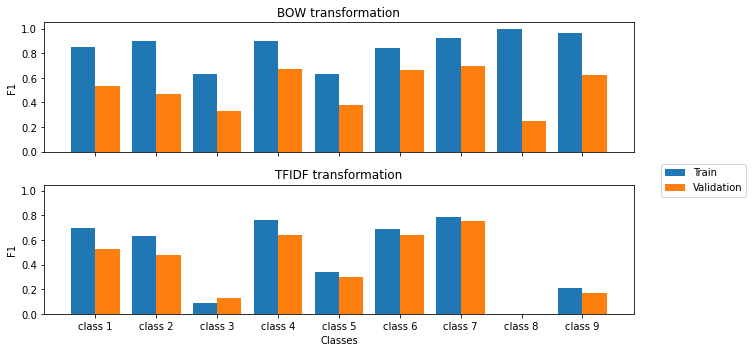

In [92]:
fig,axs = plt.subplots(2,sharex=True,sharey= 'col')
X = target_names
y = bow_train_f1_df["F1"]
z = bow_val_f1_df["F1"]

a = tfidf_train_f1_df['F1']
b = tfidf_val_f1_df['F1']
X_axis = np.arange(len(X))

axs[0].bar(X_axis - 0.2, y, 0.4, label = 'Train')
axs[0].bar(X_axis + 0.2, z, 0.4, label = 'Validation')
axs[0].set_title("BOW transformation")
axs[0].set_ylabel("F1")

axs[1].bar(X_axis - 0.2, a, 0.4, label = 'Train')
axs[1].bar(X_axis + 0.2, b, 0.4, label = 'Validation')
axs[1].set_title("TFIDF transformation")
axs[1].set_ylabel("F1")

plt.xticks(X_axis, X)
plt.xlabel("Classes")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.2))
plt.show()

In [93]:
bow_model = LogisticRegression(multi_class='multinomial', solver='lbfgs') # define the multinomial logistic regression model
bow_model.fit(X_train_bow,y_train)    

LogisticRegression(multi_class='multinomial')

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [108]:
cf_bow_train = confusion_matrix(y_train,bow_result['predict_train'])
cf_bow_val = confusion_matrix(y_validation,bow_result['predict_val'])
cf_tfidf_train = confusion_matrix(y_train,tfidf_result['predict_train'])
cf_tfidf_val = confusion_matrix(y_validation,tfidf_result['predict_val'])

#### Confusion Matrix for all the classes for BOW and TFIDF transformation

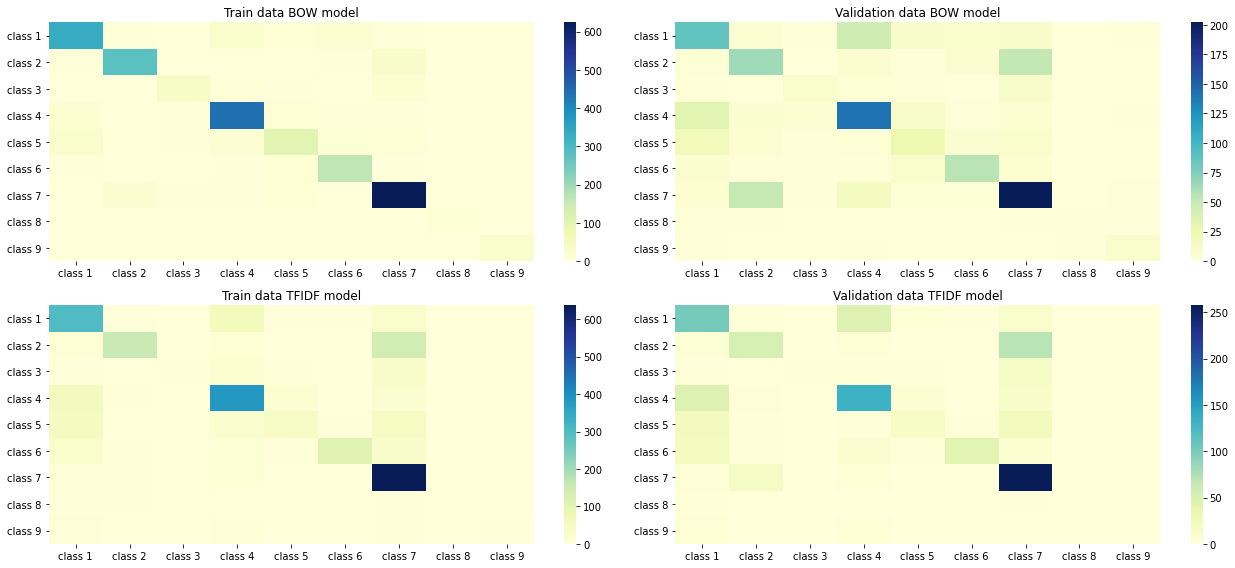

In [118]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,8))
sns.heatmap(cf_bow_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,0])
axes[0,0].set_title('Train data BOW model')
sns.heatmap(cf_bow_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,1])
axes[0,1].set_title('Validation data BOW model')
sns.heatmap(cf_tfidf_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,0])
axes[1,0].set_title('Train data TFIDF model')
sns.heatmap(cf_tfidf_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,1])
axes[1,1].set_title('Validation data TFIDF model')
plt.tight_layout()

### Inference from the analyzing the scoring matrix

#### The bag of words transformation overfits to the training data with low log loss and higher F1 scores across all classes. The TFIDF transformation produces a more balanced result, making it a better choice for building models. Both the transformations show a variation in the degree of prediction for different classes

### <font color='blue'> Multinomial Naive Bayes Model<font>

Naive Bayes classification technique is based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. It works well with discrete data and is a method of choice for text classification

In [75]:
from sklearn.naive_bayes import MultinomialNB

In [73]:
def naive_bayes(x_train,y_train,x_val,y_val):
    model = MultinomialNB() # define the Naive bayes model
    model.fit(x_train,y_train)
    print(model.class_count_)
    predict_proba_train = model.predict_proba(x_train)
    predict_proba_val = model.predict_proba(x_val)
    predict_train = model.predict(x_train)
    predict_val = model.predict(x_val)
    result = {"predict_proba_train":predict_proba_train,"predict_proba_val":predict_proba_val,"predict_train":predict_train,"predict_val":predict_val}
    return result   

In [76]:
bow_result = naive_bayes(X_train_bow,y_train,X_validation_bow,y_validation)

In [77]:
tfidf_result = naive_bayes(X_train_tfidf,y_train,X_validation_tfidf,y_validation)

### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [78]:
bow_train_LR_logloss = log_loss(y_train,bow_result['predict_proba_train'])
bow_val_LR_logloss = log_loss(y_validation,bow_result['predict_proba_val'])
tfidf_train_LR_logloss = log_loss(y_train,tfidf_result['predict_proba_train'])
tfidf_val_LR_logloss = log_loss(y_validation,tfidf_result['predict_proba_val'])

### Log Loss score for Naive Bayes model for BOW and TFIDF transformation

In [79]:
pd.DataFrame({"transformer model":['Bag of words','TFIDF'],"Train Data":[bow_train_LR_logloss,tfidf_train_LR_logloss],"Validation Data":[bow_val_LR_logloss,tfidf_val_LR_logloss]})

,transformer model,Train Data,Validation Data
0,Bag of words,13.659378,16.278347
1,TFIDF,1.226115,1.360232


In [84]:
bow_train_f1 = get_f1(y_train,bow_result['predict_train'])
bow_val_f1 = get_f1(y_validation,bow_result['predict_val'])

In [85]:
tfidf_train_f1 = get_f1(y_train,tfidf_result['predict_train'])
tfidf_val_f1 = get_f1(y_validation,tfidf_result['predict_val'])

In [88]:
bow_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_train_f1,"dataset":train_label})
bow_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_val_f1,"dataset":validation_label})
bow_f1_df = pd.concat([bow_train_f1_df,bow_val_f1_df])

In [89]:
bow_train_f1_df['F1'] = pd.to_numeric(bow_train_f1_df['F1'])
bow_val_f1_df['F1'] = pd.to_numeric(bow_val_f1_df['F1'])
bow_f1_df['F1'] = pd.to_numeric(bow_f1_df['F1'])

In [90]:
tfidf_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_train_f1,"dataset":train_label})
tfidf_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_val_f1,"dataset":validation_label})
tfidf_f1_df = pd.concat([tfidf_train_f1_df,tfidf_val_f1_df])

In [91]:
tfidf_train_f1_df['F1'] = pd.to_numeric(tfidf_train_f1_df['F1'])
tfidf_val_f1_df['F1'] = pd.to_numeric(tfidf_val_f1_df['F1'])
tfidf_f1_df['F1'] = pd.to_numeric(tfidf_f1_df['F1'])

### F1 scores for all the classes for Naive Bayes model

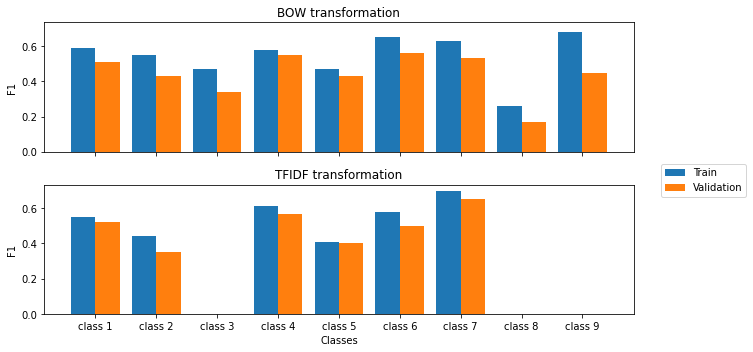

In [92]:
fig,axs = plt.subplots(2,sharex=True,sharey= 'col')
X = target_names
y = bow_train_f1_df["F1"]
z = bow_val_f1_df["F1"]

a = tfidf_train_f1_df['F1']
b = tfidf_val_f1_df['F1']
X_axis = np.arange(len(X))

axs[0].bar(X_axis - 0.2, y, 0.4, label = 'Train')
axs[0].bar(X_axis + 0.2, z, 0.4, label = 'Validation')
axs[0].set_title("BOW transformation")
axs[0].set_ylabel("F1")

axs[1].bar(X_axis - 0.2, a, 0.4, label = 'Train')
axs[1].bar(X_axis + 0.2, b, 0.4, label = 'Validation')
axs[1].set_title("TFIDF transformation")
axs[1].set_ylabel("F1")

plt.xticks(X_axis, X)
plt.xlabel("Classes")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.2))
plt.show()

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [95]:
cf_bow_train = confusion_matrix(y_train,bow_result['predict_train'])
cf_bow_val = confusion_matrix(y_validation,bow_result['predict_val'])
cf_tfidf_train = confusion_matrix(y_train,tfidf_result['predict_train'])
cf_tfidf_val = confusion_matrix(y_validation,tfidf_result['predict_val'])

### Confusion Matrix for all the classes for BOW and TFIDF transformation

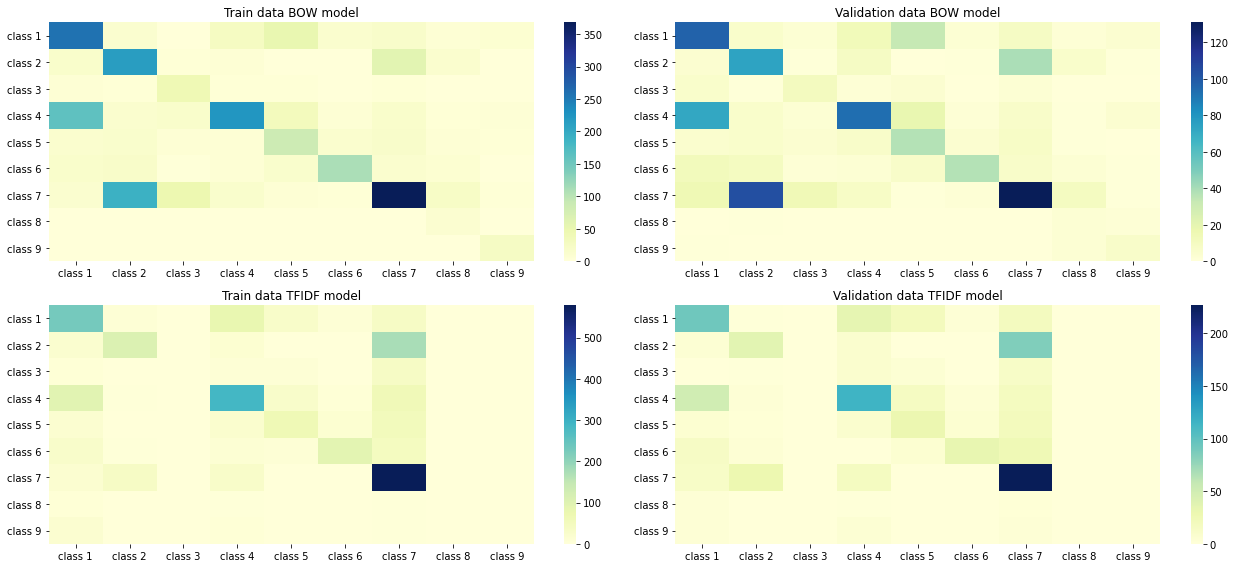

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,8))
sns.heatmap(cf_bow_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,0])
axes[0,0].set_title('Train data BOW model')
sns.heatmap(cf_bow_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,1])
axes[0,1].set_title('Validation data BOW model')
sns.heatmap(cf_tfidf_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,0])
axes[1,0].set_title('Train data TFIDF model')
sns.heatmap(cf_tfidf_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,1])
axes[1,1].set_title('Validation data TFIDF model')
plt.tight_layout()

### <font color='blue'> The Naive Bayes Classifier has performed poorly with the BOW model. One reason could be that there exists a relationship between the features. Without correction, the Naive Bayes model cannot be used with continious data and hence we are not modeling the TFIDF data </font>

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework

In [222]:
!pip install xgboost

distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None


In [223]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

In [227]:
# fit model no training data
xg_boost_model = XGBClassifier()

In [225]:
params=[{'n_estimators':[10,50,100]},{'max_depth':[1,4,6]},{'min_samples_split':[2,4]}]

In [226]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

#### fitting the BOW model

In [229]:
xgb_grid_bow=GridSearchCV(estimator=xg_boost_model, param_grid=params,cv=cv,verbose=1)
xgb_grid_bow.fit(X_train_bow, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[00:02:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:

[00:16:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:18:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:18:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[00:28:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                           

#### saving the model

In [236]:
import pickle

In [237]:
pickle.dump(xgb_grid_bow,open("xgb_grid_bow.sav","wb"))

In [230]:
y_pred_train_XGB=xgb_grid_bow.predict_proba(X_train_bow)

In [231]:
y_pred_train_XGB2=xgb_grid_bow.predict(X_train_bow)

#### scoring the prediction using mutiple metrics

In [232]:
log_loss(y_train,y_pred_train_XGB)

0.2063185496522016

In [233]:
print(classification_report(y_train, y_pred_train_XGB2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.85      0.88      0.86       396
     class 2       0.96      0.91      0.94       317
     class 3       0.61      0.69      0.65        62
     class 4       0.92      0.92      0.92       480
     class 5       0.80      0.67      0.73       170
     class 6       0.91      0.93      0.92       191
     class 7       0.93      0.96      0.95       666
     class 8       1.00      0.92      0.96        13
     class 9       1.00      0.92      0.96        26

    accuracy                           0.90      2321
   macro avg       0.89      0.87      0.88      2321
weighted avg       0.90      0.90      0.90      2321



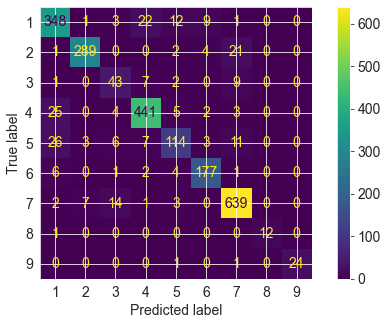

In [234]:
plot_confusion_matrix(xgb_grid_bow, X_train_bow, y_train)

### The XGBoost model has performed well with the bag of words transformation, with a low log loss score and high F1 scores

 #### fitting the TFIDF model

In [235]:
xgb_grid_tfidf=GridSearchCV(estimator=xg_boost_model, param_grid=params,cv=cv,verbose=1)
xgb_grid_tfidf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[01:05:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:05:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:05:

[01:33:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[01:57:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                           

#### saving the model

In [238]:
pickle.dump(xgb_grid_tfidf,open("xgb_grid_tfidf.sav","wb"))

In [239]:
y_pred_train_XGB_tfidf=xgb_grid_tfidf.predict_proba(X_train_tfidf)

In [240]:
y_pred_train_XGB_tfidf2=xgb_grid_tfidf.predict(X_train_tfidf)

#### scoring the prediction using multiple metrics

In [241]:
log_loss(y_train,y_pred_train_XGB_tfidf)

0.22186248091138572

In [242]:
print(classification_report(y_train, y_pred_train_XGB_tfidf2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.86      0.87      0.86       396
     class 2       0.96      0.91      0.94       317
     class 3       0.60      0.74      0.66        62
     class 4       0.91      0.92      0.92       480
     class 5       0.77      0.69      0.73       170
     class 6       0.91      0.93      0.92       191
     class 7       0.94      0.95      0.94       666
     class 8       0.93      1.00      0.96        13
     class 9       1.00      0.92      0.96        26

    accuracy                           0.90      2321
   macro avg       0.88      0.88      0.88      2321
weighted avg       0.90      0.90      0.90      2321



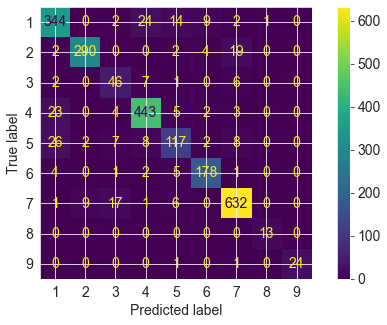

In [243]:
plot_confusion_matrix(xgb_grid_tfidf, X_train_tfidf, y_train)

### <font color='blue'> XGBoost has performed well with the TFIDF transformed dataset, with a low log loss score and high F1 scores </font>

### Validation dataset

In [250]:
validation_df_corpus = validation_df['cleaned_text'].tolist()

##### Bag of words transformation

In [251]:
validation_df_counts= bow_vectorizer.transform(validation_df_corpus)

In [252]:
validation_df_counts.shape

(995, 1600)

In [253]:
X_validation_bow = validation_df_counts.todense()

In [254]:
X_validation_bow.shape

(995, 1600)

In [255]:
X_validation_bow[0]

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Logistic Regression Model

In [256]:
y_pred_validation_bow = bow_model.predict_proba(X_validation_bow)

In [257]:
y_pred_validation_bow2 = bow_model.predict(X_validation_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [258]:
set(y_validation.tolist())

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [259]:
log_loss(y_validation,y_pred_validation_bow)

3.1523235517938732

In [260]:
print(classification_report(y_validation, y_pred_validation_bow2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.52      0.54      0.53       170
     class 2       0.55      0.53      0.54       135
     class 3       0.30      0.33      0.32        27
     class 4       0.68      0.71      0.69       206
     class 5       0.38      0.35      0.36        72
     class 6       0.62      0.60      0.61        82
     class 7       0.70      0.70      0.70       286
     class 8       0.20      0.17      0.18         6
     class 9       0.80      0.73      0.76        11

    accuracy                           0.60       995
   macro avg       0.53      0.52      0.52       995
weighted avg       0.60      0.60      0.60       995



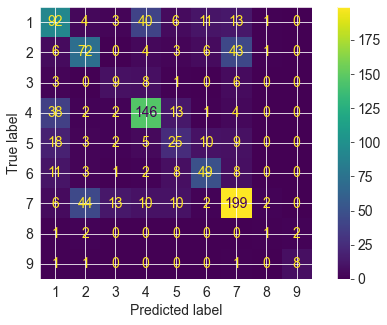

In [261]:
plot_confusion_matrix(bow_model, X_validation_bow, y_validation)

### <font color='blue'> the logistic regression model underperforms with the validation dataset, with high log loss and low F1 scores. The better statistics with training dataset means that the model is overfitting and needs regularization </font>

##### TFIDF transformation

In [262]:
X_validate_tfidf = tfidf_vectorizer.transform(validation_df_corpus)

In [263]:
X_validate_tfidf = X_validate_tfidf.toarray()

In [264]:
y_pred_validate_tfidf = tfidf_model.predict_proba(X_validate_tfidf)

In [265]:
y_pred_validate_tfidf2 = tfidf_model.predict(X_validate_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [266]:
log_loss(y_validation,y_pred_validate_tfidf)

1.0961563283230227

In [267]:
print(classification_report(y_validation, y_pred_validate_tfidf2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.53      0.61      0.57       170
     class 2       0.70      0.43      0.53       135
     class 3       1.00      0.04      0.07        27
     class 4       0.65      0.74      0.69       206
     class 5       0.48      0.29      0.36        72
     class 6       0.82      0.51      0.63        82
     class 7       0.66      0.90      0.76       286
     class 8       0.00      0.00      0.00         6
     class 9       1.00      0.09      0.17        11

    accuracy                           0.64       995
   macro avg       0.65      0.40      0.42       995
weighted avg       0.65      0.64      0.61       995



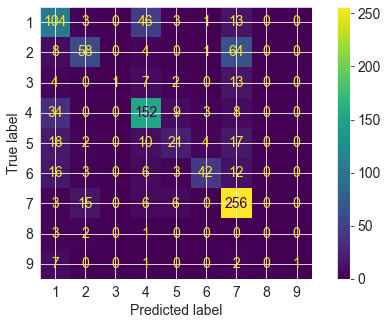

In [273]:
plot_confusion_matrix(tfidf_model, X_validate_tfidf, y_validation)

### <font color='blue'> The logistic regression model, with the TFIDF transformation, shows similar log loss as the training dataset. However, for both training and validation datasets, the classification report shows that precision and recall for several of the classes is poor. This will cause problems, while handling imbalanced datasets </font> 

### <font color='blue'>Now we shall test the XGBoost model with the validation dataset</font>

#### Bag of words transformation

In [270]:
y_pred_validate_XGB=xgb_grid_bow.predict_proba(X_validation_bow)

In [271]:
y_pred_validate_XGB2=xgb_grid_bow.predict(X_validation_bow)

#### scoring the prediction with multiple scoring metrics

In [272]:
log_loss(y_validation,y_pred_validate_XGB)

1.1280003805424557

In [274]:
print(classification_report(y_validation, y_pred_validate_XGB2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.54      0.59      0.56       170
     class 2       0.62      0.49      0.55       135
     class 3       0.38      0.33      0.35        27
     class 4       0.69      0.70      0.70       206
     class 5       0.46      0.38      0.41        72
     class 6       0.81      0.62      0.70        82
     class 7       0.70      0.81      0.75       286
     class 8       0.00      0.00      0.00         6
     class 9       0.80      0.73      0.76        11

    accuracy                           0.64       995
   macro avg       0.55      0.52      0.53       995
weighted avg       0.64      0.64      0.64       995



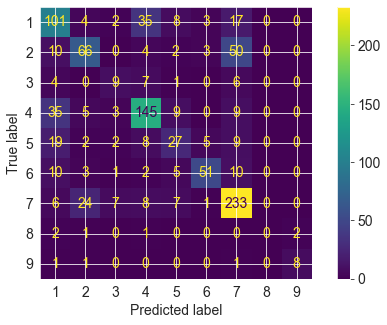

In [275]:
plot_confusion_matrix(xgb_grid_bow, X_validation_bow, y_validation)

### <font color ='blue'>The xgboost model on the Bag of words transformed data, performs OK, with respect to the overall log loss score, but analyzing the classification report shows, that the F1 score is poor for several classes, and so this model will underperform with imbalanced datasets</font>

#### TFIDF transformation 

In [276]:
y_pred_validate_XGB_tfidf=xgb_grid_tfidf.predict_proba(X_validate_tfidf)

In [277]:
y_pred_validate_XGB_tfidf2=xgb_grid_tfidf.predict(X_validate_tfidf)

#### scoring the prediction with multiple scoring metrics

In [278]:
log_loss(y_validation,y_pred_validate_XGB_tfidf)

1.0315134298175705

In [279]:
print(classification_report(y_validation, y_pred_validate_XGB_tfidf2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.57      0.61      0.59       170
     class 2       0.69      0.53      0.60       135
     class 3       0.41      0.33      0.37        27
     class 4       0.68      0.72      0.70       206
     class 5       0.49      0.39      0.43        72
     class 6       0.80      0.62      0.70        82
     class 7       0.72      0.84      0.77       286
     class 8       0.00      0.00      0.00         6
     class 9       0.80      0.73      0.76        11

    accuracy                           0.66       995
   macro avg       0.57      0.53      0.55       995
weighted avg       0.66      0.66      0.66       995



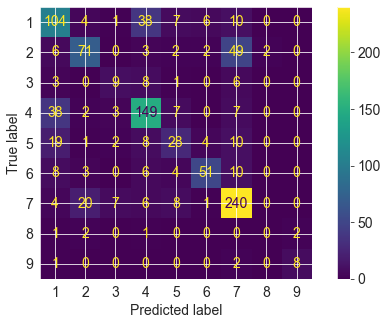

In [281]:
plot_confusion_matrix(xgb_grid_tfidf, X_validate_tfidf, y_validation)

### <font color='blue'> A margin improvement is seen in the log loss score by using the TFIDF transformed dataset. However, the uneven efficiency in predicting the individual classes, remains a concern</font>

#### handling the test text sample data

In [ ]:
#test_text_df.sort_values(['ID']).head()

In [ ]:
#test_text_df.shape

In [ ]:
#test_text_df['cleaned_text'] = test_text_df['Text'].map(cleanse_data,na_action='ignore')

In [ ]:
#test_text_df['cleaned_text'] = test_text_df['cleaned_text'].map(reduce_words)

In [ ]:
#test_text_df['cleaned_text_vector'] = test_text_df['cleaned_text'].map(word_count)

In [ ]:
#test_text_df['sorted_cleaned_text_vector'] = test_text_df['cleaned_text'].progress_map(freq_dist)

In [ ]:
#test_text_df = test_text_df.drop(['Text'],axis=1)

In [ ]:
#test_text_df.head()

In [ ]:
# get the text samples as list
#test_corpus = test_text_df['cleaned_text'].tolist()

In [ ]:
# transform the test case to get bag of words
#test_bag_of_words_train = bow_vectorizer.fit_transform(test_corpus)

In [ ]:
# convert the dictionary to an array
#test_bag_of_words_array = test_bag_of_words_train.toarray()

In [ ]:
#test_bag_of_words_array.shape

In [ ]:
# predict test using bag of word model
#y_pred_test_bow = bow_model.predict_proba(test_bag_of_words_array)

In [ ]:
#y_pred_test_bow[0]

In [ ]:
#y_pred_test_df = pd.DataFrame(y_pred_test_bow)

In [ ]:
#test_text_df['ID'].shape

In [ ]:
#y_pred_test_df['ID']= test_text_df['ID'].reset_index(drop=True)

In [ ]:
#y_pred_test_df.head()

In [ ]:
# predict test using tfidf model
#y_pred_test_tfidf = tfidf_model.predict_proba(test_bag_of_words_array)

In [ ]:
stage2_test_text_df = pd.read_csv('stage2_test_text.csv', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"])


In [ ]:
stage2_test_text_df.shape

In [ ]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['Text'].progress_map(cleanse_data,na_action='ignore')

In [ ]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['cleaned_text'].progress_map(reduce_words)

In [ ]:
stage2_test_text_df.shape

In [ ]:
stage2_cleaned_view =pd.DataFrame({"Text":stage2_test_text_df['Text'].progress_map(lambda x:len(x)),"cleaned_text":stage2_test_text_df['cleaned_text'].map(lambda x:len(x))})
stage2_cleaned_view.head()

In [ ]:
stage2_test_corpus = stage2_test_text_df['cleaned_text'].tolist()

In [ ]:
#X_stage2_test = bow_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [ ]:
X_stage2_test = tfidf_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [ ]:
X_stage2_test.shape

In [ ]:
y_pred_stage2 = tfidf_model.predict_proba(X_stage2_test)

In [ ]:
y_pred_stage2.shape

In [ ]:
y_pred_stage2_df = pd.DataFrame(y_pred_stage2)

In [ ]:
y_pred_stage2_df['ID']=stage2_test_text_df['ID']

In [ ]:
y_pred_stage2_df.columns

In [ ]:
y_pred_stage2_df.columns = ['class1','class2','class3','class4','class5','class6','class7','class8','class9','ID']

In [ ]:
y_pred_stage2_df=y_pred_stage2_df[['ID','class1','class2','class3','class4','class5','class6','class7','class8','class9']]

In [ ]:
y_pred_stage2_df.head()

In [ ]:
y_pred_stage2_df.to_csv("y_pred_stage2.csv",index=False)

In [ ]:
df=pd.DataFrame(columns=["Gene","Class","Variation","cleaned_text","cleaned_freq"])
for i in range(19):    
    df_new=class_9[class_9['cleaned_text'] == class_9['cleaned_text'].unique()[i]]
    df=pd.concat([df,df_new])

we have sorted the frequency dictionary based on values using the key parameter of sorted and higher values first using reverse

In [ ]:
sorted(test_dic.items(),key=lambda x:x[1], reverse=True)

In [ ]:
for i in range(10):
    print(scan_data1[i])

In [ ]:
cd /content

In [ ]:
pa_tree=ET.parse('pa2021.xml')

In [ ]:
root=pa_tree.getroot()

In [ ]:
# for child in root:
#   print(child.tag)

In [ ]:
for element_1 in root:
  #print("---------level_1-----------")
  #print(element_1.tag)
  
  for element_2 in element_1:
    #print("---------level_2-----------")
    #print("    "+element_2.tag," ",element_2.text)
    
    for element_3 in element_2:
      #print("---------level_3-----------")
      #print("        "+element_3.tag," ",element_3.text)
      
      for element_4 in element_3:
        #print("---------level_4-----------")
        if element_4.tag=="String":
          print("                   "+element_4.tag," ",element_4.text)
          
  #break
    

In [ ]:
len(root)

In [ ]:
desc_tree=ET.parse('desc2021.xml')

In [ ]:
desc_root=desc_tree.getroot()

In [ ]:
len(desc_root)

In [ ]:
term_description=[]
for element_1 in desc_root:
  #print("-------level_1----------")
  #print(element_1.tag," ",element_1.text)
  for element_2 in element_1:
    #print("    ----------level_2----------")
    #print("    "+element_2.tag," ",element_2.text)
    for element_3 in element_2:
      if element_3.tag=='String':
        #print("        ---------level_3--------")
        #print("        "+element_3.tag," ",element_3.text)
        term_description.append(element_3.text)

  #break

In [ ]:
len(term_description)

In [ ]:
term_description[:10]

In [ ]:
import csv 
with open('term_description.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(term_description) 
    

There are 2 ways to remove punctuation. one is to use the string library punctuation module on the text before tokenization, the other is to use the nltk.punct library

In [ ]:
len(scan_data1[1])

In [ ]:
#nltk.word_tokenize(scan_data1[1])

In [ ]:
# import string punctuation
import string
string.punctuation

In [ ]:
len(cleanup_text(scan_data1[1]))

In [ ]:
scan_data